# CSCI 3202, Spring 2022: Final Coding Project

---


This is your final programming project for CSCI 3202. It is due on Canvas by **11:59 PM on Saturday April 30**.  Your solutions to theoretical questions should be done in Markdown/LateX directly below the associated question. Your solutions to computational questions should include any relevant Python code, as well as results and any written commentary.

You have two options for completing your final project for this course. The first option is presented in this notebook and involves implementing a reinforcement learning algorithm and producing a five-minute video that explains your process of solving this problem. The second option is to design your own project that includes the algorithms we've discussed since the midterm - Bayes Nets, Hidden Markov Models, Markov Decision Processes, or Reinforcement Learning - or an algorithm related to one of these that we haven't discussed in class. Your project also needs to include some kind of analysis of how it performed on a specific problem. If you're interested in the design your own project option, you need to discuss your idea with one of the course instructors to get approval. If you do a project without getting approval, you will receive a 0 regardless of the quality of the project. You will also need to produce a short, five-minute video that explains your project.

**The rules:**

1. Choose EITHER the given problem to submit OR choose your own project topic. 

2. If you choose your own project topic, please adhere to the following guidelines:
- The project needs to be approved by the course instructors.
- The project needs to include one of the algorithms we've discussed since the midterm - Bayes Nets, HMMs, MDPs, or Reinforcement Learning - or an algorithm that we haven't discussed in class. 
- If you do your own project without prior approval, you will receive a 0 for this project.
- Your project code, explanation, and results must all be contained in a Jupyter notebook. 

3. All work, code and analysis must be **your own**.
4. You may use your course notes, posted lecture slides, textbook, in-class notebooks and homework solutions as resources.  You may also search online for answers to general knowledge questions, like the form of a probability distribution function, or how to perform a particular operation in Python. You may not use entire segments of code as solutions to any part of this project, e.g. if you find a Python implementation of policy iteration online, you can't use it.
5. You may **not** post to message boards or other online resources asking for help.
6. **You may not collaborate with classmates or anyone else.**
7. This is meant to be like a coding portion of your final exam. So, we will be much less helpful than we typically am with homework. For example, we will not check answers, help debug your code, and so on.
8. If you have a question, post it first as a **private** Piazza message. If we decide that it is appropriate for the entire class, then we will make it a public post (and anonymous).
9. If something is left open-ended, it is probably because we intend for you to code it up however you want, and only care about the plots/analysis we see at the end. Feel free to ask clarifying questions though.

Violation of these rules will result in an **F** and a trip to the Honor Code council.

---
**By writing your name below, you agree to abide by these rules:**

**Your name: Scott Randolph**

---



In [1]:
import random
import math
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from collections import defaultdict

# added packages
import heapq
from matplotlib import colors



---
## [100 pts] Problem 1:  Reinforcement learning

Consider a **cube** state space defined by $0 \le x, y, z \le L$. Suppose you are piloting/programming a drone to learn how to land on a platform at the center of the $z=0$ surface (the bottom). Some assumptions:
* In this discrete world, if the drone is at $(x,y,z)$ it means that the box is centered at $(x,y,z)$. There are boxes (states) centered at $(x,y,z)$ for all $0 \le x,y,z \le L$. Each state is a 1 unit cube. So when $L=2$ (for example), there are cubes centered at each $x=0,1,2$, $y=0,1,2$ and so on, for a total state space size of $3^3 = 27$ states.
* All of the states with $z=0$ are terminal states.
* The state at the center of the bottom of the cubic state space is the landing pad. For example, when $L=4$, the landing pad is at $(x,y,z) = (2,2,0)$.
* All terminal states ***except*** the landing pad have a reward of -1. The landing pad has a reward of +1.
* All non-terminal states have a living reward of -0.01.
* The drone takes up exactly 1 cubic unit, and begins in a random non-terminal state.
* The available actions in non-terminal states include moving exactly 1 unit Up (+z), Down (-z), North (+y), South (-y), East (+x) or West (-x). In a terminal state, the training episode should end.

#### Part A
Write a class `MDPLanding` to represent the Markov decision process for this drone. Include methods for:
1. `actions(state)`, which should return a list of all actions available from the given state
2. `reward(state)`, which should return the reward for the given state
3. `result(state, action)`, which should return the resulting state of doing the given action in the given state

and attributes for:
1. `states`, a list of all the states in the state space, where each state is represented as an $(x,y,z)$ tuple
2. `terminal_states`, a dictionary where keys are the terminal state tuples and the values are the rewards associated with those terminal states
3. `default_reward`, a scalar for the reward associated with non-terminal states
4. `all_actions`, a list of all possible actions (Up, Down, North, South, East, West)
5. `discount`, the discount factor (use $\gamma = 0.999$ for this entire problem)

How you feed arguments/information into the class constructor is up to you.

Note that actions are *deterministic* here.  The drone does not need to learn transition probabilities for outcomes of particular actions. What the drone does need to learn, however, is where the landing pad is, and how to get there from any initial state.

Before moving on to Part B, we recommend that you test that your MDPLanding code is set up correctly. Write unit tests that display the actions for a given state, rewards, results, etc. This will help you identify errors in your implementation and save you a lot of debugging time later.

In [2]:
# Your code here.
class MDPLanding:
    def __init__(self, L, default_reward, good_term_state, bad_term_state):
        self.default_reward = default_reward
        self.all_actions = ['Up', 'Down', 'North', 'South', 'East', 'West']
        self.discount = .999
        self.states = []
        self.terminal_states = {}
        self.L = L
        
        for i in range(L):
            for j in range(L):
                for k in range(L):
                    self.states.append((i,j,k))
        
        for i in range(L):
            for j in range(L):
                self.terminal_states[(i,j,0)] = bad_term_state
        self.terminal_states[int(L/2), int(L/2), 0] = good_term_state
        
    def actions(self, state):
        actions = []
        if state[2] == 0:
            actions.append('Down')
        else:
            if state[0] < self.L:
                actions.append('East')
            if state[0] > 0:
                actions.append('West')
            if state[1] < self.L:
                actions.append('North')
            if state[1] > 0:
                actions.append('South')
            if state[2] < self.L:
                actions.append('Up')
            if state[2] > 0:
                actions.append('Down') 
        return actions
        
    def reward(self, state):
        if state in self.terminal_states:
            return self.terminal_states[state]
        else:
            return self.default_reward
        
    def result(self, state, action):
        trans_tup = (-1,-1,-1)
        if action == 'Up':
            trans_tup = (0,0,1)
        elif action == 'Down':
            trans_tup = (0,0,-1)
        elif action == 'North':
            trans_tup = (0,1,0)
        elif action == 'South':
            trans_tup = (0,-1,0)
        elif action == 'East':
            trans_tup = (1,0,0)
        elif action == 'West':
            trans_tup = (-1,0,0)
            
        new_tup = (state[0]+trans_tup[0], state[1]+trans_tup[1], state[2]+trans_tup[2])
        if new_tup in self.states:
            return new_tup
        else:
            return state

In [3]:
testMDP = MDPLanding(3, -0.01, 1, -1)

for x in testMDP.all_actions:  
    print(x, testMDP.result((1,1,1), x))
print()

print(testMDP.actions((1,1,1)))
print(testMDP.reward((1,1,1)))
print(testMDP.reward((1,1,0)))
print(testMDP.reward((0,0,0)))

Up (1, 1, 2)
Down (1, 1, 0)
North (1, 2, 1)
South (1, 0, 1)
East (2, 1, 1)
West (0, 1, 1)

['East', 'West', 'North', 'South', 'Up', 'Down']
-0.01
1
-1


#### Part B
Write a function to implement **policy iteration** for this drone landing MDP. Create an MDP environment to represent the $L=4$ case (so 125 total states).

Use your function to find an optimal policy for your new MDP environment. Check (by printing to screen) that the policy for the following states are what you expect, and **comment on the results**:
1. $(2,2,1)$
1. $(0,2,1)$
1. $(2,0,1)$

The policy for each of these states is the action that the agent should take in that state. 

In [4]:
# Your code here.
def policy_iteration(MDP):
    gamma = MDP.discount
    state_utils = {}
    state_pols = {}
    actions = MDP.all_actions
    
    for i in MDP.states:
        state_utils[i] = MDP.reward(i)
        state_pols[i] = 'Up'
    
    changed = True
    #while a change was made for a policy, continue 
    while (changed):
        changed = False
        new_utils = {}
        #policy evaluation
        for i in state_utils:
            #only evaluate non-terminal states
            if i[2] != 0:
                U = []
                #get the current max utility for the current state
                for a in actions:
                    U.append(gamma * state_utils[MDP.result(i, a)])
                new_utils[i] = max(U)
                #if state is terminal no evaluation needed
            else:
                new_utils[i] = state_utils[i]
                #set state_utils to new updated utils
        state_utils = new_utils

        
        #policy improvement
        for i in state_pols:
            #only check for improvements on non-terminal states
            if i[2] != 0:
                P = {}
                #get all utils for the current state
                for a in actions:
                    P[state_utils[MDP.result(i, a)]] = a
                #if the policy associated with the max utility is different from the current policy update the policy
                if P[max(P)] != state_pols[i]:
                    state_pols[i] = P[max(P)]
                    changed = True
                #print(i, state_pols[i], P)
        
#     for i in state_utils:
#         print(i, state_utils[i])
    
    return state_pols

In [5]:
L = 5
piMDP = MDPLanding(L, -0.01, 1, -1)
policies = policy_iteration(piMDP)
#print(policies[(2,2,1)])

for z in range(L):
    zplane = ""
    for y in range(L):
        for x in range(L):
            if policies[(x,y,z)] == 'Up':
                zplane += '+'
            elif policies[(x,y,z)] == 'Down':
                zplane += '-'
            elif policies[(x,y,z)] == 'North':
                zplane += 'V'
            elif policies[(x,y,z)] == 'South':
                zplane += '^'
            elif policies[(x,y,z)] == 'East':
                zplane += '>'
            else:
                zplane += '<'
        zplane += '\n'
    print(zplane)

+++++
+++++
+++++
+++++
+++++

>>V<<
>>V<<
>>-<<
>>^<<
>>^<<

>>V<<
>>V<<
>>-<<
>>^<<
>>^<<

>>V<<
>>V<<
>>-<<
>>^<<
>>^<<

>>V<<
>>V<<
>>-<<
>>^<<
>>^<<



In [6]:
print(policies[(2,2,1)])
print(policies[(0,2,1)])
print(policies[(2,0,1)])

Down
East
North


the policy generated is to funnel towards the middle then down to the landing platorm. This makes sense and is supported by the results of the three tests.

#### Part C

Code up a **Q-learning** agent/algorithm to learn how to land the drone. You can do this however you like, as long as you use the MDP class structure defined above.  

Your code should include some kind of a wrapper to run many trials to train the agent and learn the Q values.  You also do not need to have a separate function for the actual "agent"; your code can just be a "for" loop within which you are refining your estimate of the Q values.

From each training trial, save the cumulative discounted reward (utility) over the course of that episode. That is, add up all of $\gamma^t R(s_t)$ where the drone is in state $s_t$ during time step $t$, for the entire sequence. We refer to this as "cumulative reward" because we usually refer to "utility" as the utility *under an optimal policy*.

Some guidelines:
* The drone should initialize in a random non-terminal state for each new training episode.
* The training episodes should be limited to 50 time steps, even if the drone has not yet landed. If the drone lands (in a terminal state), the training episode is over.
* You may use whatever learning rate $\alpha$ you decide is appropriate, and gives good results.
* There are many forms of Q-learning. You can use whatever you would like, subject to the reliability targets in Part D below.
* Your code should return:
  * The learned Q values associated with each state-action pair.
  * The cumulative reward for each training trial. 
  * Anything else that might be useful in the ensuing analysis.

In [7]:
# Your code here.
def Q_Learning(MDP, L, num_of_trials):
    a = 0.4
    Q = {}
    cumu_rewards = []
    state_pols = {}
    visited = {}
    
    for state in MDP.states:
        Q[state] = {}
        if state[2] == 0:
            for action in MDP.actions(state):
                Q[state][action] = MDP.reward(state)
        else:
            for action in MDP.actions(state):
                Q[state][action] = 0
    
    for i in MDP.states:
        state_pols[i] = 'Up'
        visited[i] = 0
    
    for x in range(num_of_trials):
        steps = 0
        current_reward = 0
        state = (random.randint(0,L-1), random.randint(0,L-1), random.randint(1,L-1))
        while steps < 50:
            if state in MDP.terminal_states:
                #calc cumu reward
                current_reward += ((MDP.discount**steps)*MDP.reward(state))
                break
            else:
                #calc e value
                e = 1-math.exp(-(visited[state]+1)/20)
                #action is exploitative option
                if np.random.choice([True, False], p=[e, 1-e]):
                    #get optimal action from state_pols
                    action = state_pols[state]
                #action is exploration option  
                else:
                    #get random exploration action
                    action = np.random.choice(sorted(Q[state], key=Q[state].get, reverse=True)[1:])
                #get new state
                new_state = MDP.result(state, action)
                #increase visitied count
                visited[state] += 1
                #set Q(s,a) based on action
                Q[state][action] = Q[state][action] + a*(MDP.reward(state)+MDP.discount*(max(Q[new_state].values()) - Q[state][action]))
                #Q[state][action] = Q[state][action]*(1-a) + a*(MDP.reward(new_state)+MDP.discount*(max(Q[new_state].values())))
                #update policy for state
                state_pols[state] = sorted(Q[state].items(), key=lambda x: x[1], reverse=True)[0][0]
                #calc cumu reward
                current_reward += ((MDP.discount**steps)*MDP.reward(state))
                #update state/steps
                state = new_state
                steps += 1
        cumu_rewards.append(current_reward)    
    
    #print(visited)
    return Q, cumu_rewards, state_pols

In [8]:
L = 10
trials = 5000
qlMDP = MDPLanding(L, -0.01, 1, -1)
Q, cumu_rewards, pols = Q_Learning(qlMDP, L, trials)

#print(cumu_rewards)
for x in range(0, trials, 500):
    start = x
    print(sum(cumu_rewards[start:start+500])/500)
    
# for z in range(L):
#     zplane = ""
#     for y in range(L):
#         for x in range(L):
#             if pols[(x,y,z)] == 'Up':
#                 zplane += '+'
#             elif pols[(x,y,z)] == 'Down':
#                 zplane += '-'
#             elif pols[(x,y,z)] == 'North':
#                 zplane += 'V'
#             elif pols[(x,y,z)] == 'South':
#                 zplane += '^'
#             elif pols[(x,y,z)] == 'East':
#                 zplane += '>'
#             else:
#                 zplane += '<'
#         zplane += '\n'
#     print(zplane)

-0.6662145883372725
0.19819950398206815
0.7620249495666481
0.7749808415984051
0.8202884804795367
0.8218517302788692
0.8505035518728016
0.8575663524262495
0.8540146803030034
0.8488633698415903


#### Part D

Initialize the $L=10$ environment (so that the landing pad is at $(5,5,0)$). Run some number of training trials to train the drone.

**How do I know if my drone is learned enough?**  If you take the mean cumulative reward across the last 5000 training trials, it should be around 0.80. This means at least about 10,000 (but probably more) training episodes will be necessary. It will take a few seconds on your computer, so start small to test your code.

**Then:** Compute block means of cumulative reward from all of your training trials. Use blocks of 500 training trials. This means you need to create some kind of array-like structure such that its first element is the mean of the first 500 trials' cumulative rewards; its second element is the mean of the 501-1000th trials' cumulative rewards; and so on. Make a plot of the block mean rewards as the training progresses. It should increase from about -0.5 initially to somewhere around +0.8.

**And:** Print to the screen the mean of the last 5000 trials' cumulative rewards, to verify that it is indeed about 0.80.

In [9]:
# Your code here.
L = 10
trials = 10000
qlMDP = MDPLanding(L, -0.01, 1, -1)
Q, cumu_rewards, pols = Q_Learning(qlMDP, L, trials)

blocks = []
for x in range(0, trials, 500):
    start = x
    blocks.append((sum(cumu_rewards[start:start+500])/500))

Last 5000 0.8648204659984816


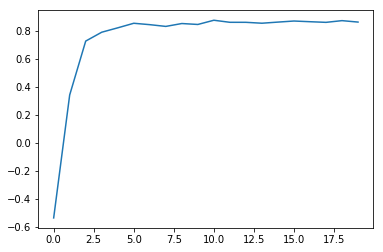

In [10]:
print('Last 5000', sum(cumu_rewards[trials-5000:])/5000)

plt.plot(list(range(20)), blocks)

#### Part E

**Question 1:** Why does the cumulative reward start off around -0.5 at the beginning of the training?

**Question 2:** Why will it be difficult for us to train the drone to reliably obtain rewards much greater than about 0.8?

Question 1:  
because a trial is limited to 50 steps and the starting living reward is .01  
-.01 * 50 = -.5  
  
Question 2:  
because the maximum reward is 1 and therefore the difference of .2 means that the drone will on average take 20 steps to reach the end. This is a reasonable assumption given an L value of 10 and the possibility for exploration  

#### Part F
Choose three other reward structures, including the terminal rewards and the living rewards, and rerun your policy iteration and Q-learning algorithms with those reward structures. Write a paragraph or two describing the reward structures that you selected, what impact you expected the changes to have on your results, and what changes actually happened. If there was a difference in what you expected and what actually happened, reflect on why there was a difference. 

In [11]:
t_rewards = [(2,-2), (5,-5), (10,-10)]
l_rewards = [-.05, -.1, -.2]

for x in range(3):
    print('Living reward:', l_rewards[x], ' Good terminal reward:', t_rewards[x][0], ' Bad terminal reward:', t_rewards[x][1])
    piMDP = MDPLanding(5, l_rewards[x], t_rewards[x][0], t_rewards[x][1])
    piPols = policy_iteration(piMDP)
    print(policies[(2,2,1)], policies[(0,2,1)], policies[(2,0,1)])
    
    qlMDP = MDPLanding(10, l_rewards[x], t_rewards[x][0], t_rewards[x][1])
    Q, cumu_rewards, pols = Q_Learning(qlMDP, 10, 3000)
    rewards = []
    for x in range(0, 4000, 500):
        start = x
        rewards.append((sum(cumu_rewards[start:start+500])/500))
    print(rewards, '\n')
    

Living reward: -0.05  Good terminal reward: 2  Bad terminal reward: -2
Down East North
[-2.569960890516359, -1.5591418279466078, 0.6102978836221659, 1.2996551849055302, 1.3627695193310716, 1.329846287185046, 0.0, 0.0] 

Living reward: -0.1  Good terminal reward: 5  Bad terminal reward: -5
Down East North
[-4.774437647688129, 1.1678504334243185, 3.1928893258088955, 3.5111210866764373, 3.6562700743518284, 3.6876366769706017, 0.0, 0.0] 

Living reward: -0.2  Good terminal reward: 10  Bad terminal reward: -10
Down East North
[-11.000711548751074, -6.2210880622406055, 3.9549298522583225, 7.147326806704783, 7.30727426232806, 7.516272915768514, 0.0, 0.0] 



For my reward structures I chose living rewards of [-.05, -.1, -.2] and for my terminal rewards I chose [(2,-2), (5,-5), (10,-10)] for the good and bad terminal states respectively. I didn't expect much of a change honestly. Maybe that's because I didn't choose meaningful values for the rewards or maybe it's because I haven't slept in over 24 hours, hard to tell. Based on the results there doesn't seem to be much of a difference. 